In [56]:
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape, TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard
from music21 import *
import glob
import numpy as np
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import History, ModelCheckpoint
from keras.optimizers import RMSprop
from datetime import datetime

In [241]:
path = '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/'

In [242]:
files = glob.glob('{}/*.mid*'.format(path))

In [243]:
KEY_SIG_OFFSET = 0 
melody_corpus = []
for i, file in enumerate(files):
    midi_stream = converter.parse(file)
    
    part0 = midi_stream[0]
    key_sig = part0.keySignature
    midi_stream.transpose(KEY_SIG_OFFSET - key_sig.tonic.pitchClass, inPlace=True)
    for m in part0.measures(1, None):
        if hasattr(m, 'flat'):
            for nr in m.flat.notesAndRests:
                pitch = nr.pitch.midi  if isinstance(nr, note.Note) else 0
                duration = float(nr.quarterLength)
                note_repr = (pitch, duration)
                melody_corpus.append(note_repr)

In [244]:
melody_set = set(melody_corpus)

In [245]:
notes_indices = {note: i for i, note in enumerate(melody_set)}
indices_notes = {i: note for i, note in enumerate(melody_set)}

In [246]:
corpus_size = len(melody_set)
print(corpus_size)

231


In [247]:
len(melody_corpus)

6999

In [248]:
phrase_len = 40
step_size = 3

In [249]:
phrases = []
next_notes = []

In [250]:
for i in range(0, len(melody_corpus) - phrase_len, step_size):
    phrases.append(melody_corpus[i: i + phrase_len])
    next_notes.append(melody_corpus[i + phrase_len])
print('nb sequences:', len(phrases))

nb sequences: 2320


In [251]:
# transform data into binary matrices
X = np.zeros((len(phrases), phrase_len, corpus_size), dtype=np.bool)
y = np.zeros((len(phrases), corpus_size), dtype=np.bool)
print(X.shape)
print(y.shape)

(2320, 40, 231)
(2320, 231)


In [252]:
for i, phrase in enumerate(phrases):
    for j, note in enumerate(phrase):
        X[i, j, notes_indices[note]] = 1
    y[i, notes_indices[next_notes[i]]] = 1

In [253]:
layer_size=128
batch_size = 128
nb_epoch = 400

In [254]:
corpus_size

231

In [255]:
phrase_len

40

In [256]:
def get_gen(G_in, phrase_len=phrase_len, corpus_size=corpus_size):
    #G_in = Input(shape=(phrase_len, corpus_size))
    layer = LSTM(layer_size, return_sequences=True)(G_in)
    layer = Dropout(0.2)(layer)
    layer = LSTM(layer_size, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = TimeDistributed(Dense(corpus_size))(layer)
    G_out = Activation('softmax')(layer)
    LSTM_out = Activation('softmax')(layer)
    G = Model(G_in, G_out)
    G.compile(loss='categorical_crossentropy', optimizer=RMSprop())
    return G, G_out
G_in = Input(shape=(phrase_len, corpus_size))
G, G_out = get_gen(G_in)
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 40, 231)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 40, 128)           184320    
_________________________________________________________________
dropout_19 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 40, 128)           131584    
_________________________________________________________________
dropout_20 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 40, 231)           29799     
_________________________________________________________________
activation_14 (Activation)   (None, 40, 231)           0         
Total para

In [257]:
def get_dis(D_in, phrase_len=phrase_len, corpus_size=corpus_size):
    layer = LSTM(layer_size, return_sequences=True)(D_in)
    layer = Dropout(0.2)(layer)
    layer = LSTM(layer_size)(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(2)(layer)
    D_out = Activation('sigmoid')(layer)
    D = Model(D_in, D_out)
    D.compile(loss='binary_crossentropy', optimizer=RMSprop())
    return D, D_out    

In [258]:
D_in = Input(shape=(phrase_len, corpus_size))

In [259]:
D, D_out = get_dis(D_in)
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 40, 231)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 40, 128)           184320    
_________________________________________________________________
dropout_21 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 258       
_________________________________________________________________
activation_16 (Activation)   (None, 2)                 0         
Total para

In [260]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable

In [261]:
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in) # ENTRADA DA GAN
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

In [262]:
GAN_in = Input(shape=(phrase_len, corpus_size))
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 40, 231)           0         
_________________________________________________________________
model_15 (Model)             (None, 40, 231)           345703    
_________________________________________________________________
model_16 (Model)             (None, 2)                 316162    
Total params: 661,865
Trainable params: 345,703
Non-trainable params: 316,162
_________________________________________________________________


In [263]:
n_samples = 100
noise_dim = X.shape[2]

In [264]:
noise_dim

231

In [265]:
X.shape

(2320, 40, 231)

In [266]:
y.shape

(2320, 231)

In [267]:
def sample_data_and_gen(G,n_samples=n_samples,noise_dim=noise_dim):
    XT = X[:n_samples]
    XN_noise = np.random.uniform(0, 1, size=[n_samples,phrase_len,noise_dim])
    XN = G.predict(XN_noise)
    print(XT.shape,XN.shape)
    XX = np.concatenate((XT, XN))
    yy = np.zeros((2*n_samples, 2))
    yy[:n_samples, 1] = 1
    yy[n_samples:, 0] = 1
    return XX, yy

In [268]:
def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=32):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)

In [269]:
pretrain(G, D,noise_dim = noise_dim, n_samples=n_samples,batch_size=1)

(100, 40, 231) (100, 40, 231)
Epoch 1/1
200/200 [==============================] - 27s - loss: 0.0712    


In [270]:
def sample_noise(G, noise_dim=10, n_samples=10000):
    X = np.random.uniform(0, 1, size=[n_samples,phrase_len, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

In [271]:
d_loss = []
g_loss = []

In [272]:
def train(GAN, G, D, epochs=100, n_samples=10, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
  e_range = range(epochs)
  for epoch in e_range:
    X, y = sample_data_and_gen(G, n_samples=10, noise_dim=noise_dim)
    set_trainability(D, True)
    a = D.train_on_batch(X, y)
    d_loss.append(D.train_on_batch(X, y))
    X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, False)
    g_loss.append(GAN.train_on_batch(X, y))
    print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
  return d_loss, g_loss

In [273]:
d_loss, g_loss = train(GAN, G, D,noise_dim=noise_dim, verbose=True)

(10, 40, 231) (10, 40, 231)
Epoch #1: Generative Loss: 12.455467224121094, Discriminative Loss: 7.231376912386622e-06
(10, 40, 231) (10, 40, 231)
Epoch #2: Generative Loss: 12.422520637512207, Discriminative Loss: 5.762132332165493e-06
(10, 40, 231) (10, 40, 231)
Epoch #3: Generative Loss: 12.57838249206543, Discriminative Loss: 5.539181529456982e-06
(10, 40, 231) (10, 40, 231)
Epoch #4: Generative Loss: 12.835405349731445, Discriminative Loss: 4.944770807924215e-06
(10, 40, 231) (10, 40, 231)
Epoch #5: Generative Loss: 13.435175895690918, Discriminative Loss: 5.397677796281641e-06
(10, 40, 231) (10, 40, 231)
Epoch #6: Generative Loss: 13.282879829406738, Discriminative Loss: 7.439819455612451e-06
(10, 40, 231) (10, 40, 231)
Epoch #7: Generative Loss: 13.275609970092773, Discriminative Loss: 5.08611265104264e-06
(10, 40, 231) (10, 40, 231)
Epoch #8: Generative Loss: 12.975847244262695, Discriminative Loss: 4.8272158892359585e-06
(10, 40, 231) (10, 40, 231)
Epoch #9: Generative Loss: 13

Epoch #70: Generative Loss: 15.925872802734375, Discriminative Loss: 1.3334940263121098e-07
(10, 40, 231) (10, 40, 231)
Epoch #71: Generative Loss: 15.953167915344238, Discriminative Loss: 1.4774141732232238e-07
(10, 40, 231) (10, 40, 231)
Epoch #72: Generative Loss: 15.969156265258789, Discriminative Loss: 1.1041072411899222e-07
(10, 40, 231) (10, 40, 231)
Epoch #73: Generative Loss: 16.03023910522461, Discriminative Loss: 1.162576950264338e-07
(10, 40, 231) (10, 40, 231)
Epoch #74: Generative Loss: 15.94488525390625, Discriminative Loss: 1.2756622425058595e-07
(10, 40, 231) (10, 40, 231)
Epoch #75: Generative Loss: 15.988433837890625, Discriminative Loss: 1.3518111074972694e-07
(10, 40, 231) (10, 40, 231)
Epoch #76: Generative Loss: 16.01241683959961, Discriminative Loss: 1.161410878580682e-07
(10, 40, 231) (10, 40, 231)
Epoch #77: Generative Loss: 15.97754192352295, Discriminative Loss: 1.1357595752770067e-07
(10, 40, 231) (10, 40, 231)
Epoch #78: Generative Loss: 15.995248794555664

Text(0,0.5,'Loss')

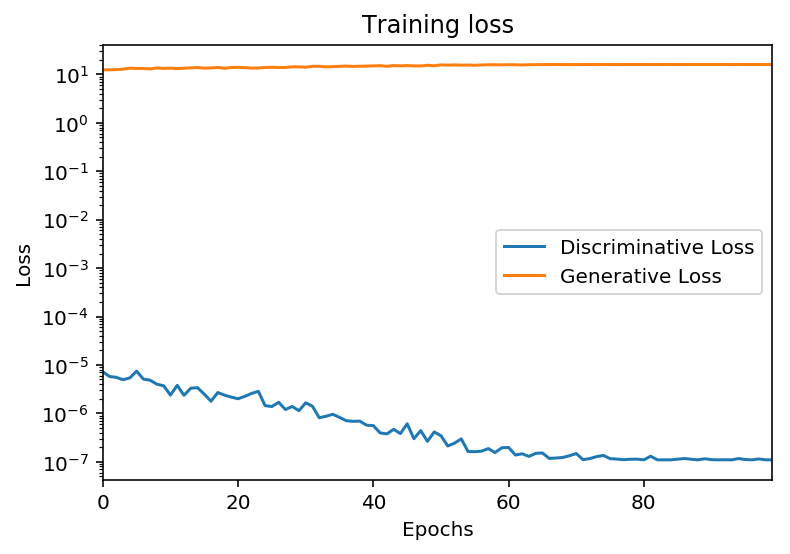

In [286]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [287]:
N_VIEWED_SAMPLES = 10
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
#pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()

(10, 40, 231) (10, 40, 231)


In [288]:
data_and_gen.shape

(20, 40, 231)

In [289]:
data_and_gen[0].shape

(40, 231)

In [290]:
np.argmax(data_and_gen[0][0]) 

38

In [291]:
indices_notes[38]

(0, 1.0)

In [292]:
nova_sequencia = []
for i,data in enumerate(data_and_gen):
    print('sample:{}'.format(i))
    for d in data:
        j = np.argmax(d)
        n = indices_notes[j]
        nova_sequencia.append(n)
        print(n)

sample:0
(0, 1.0)
(60, 0.25)
(60, 0.25)
(0, 0.5)
(60, 0.25)
(60, 0.25)
(0, 0.5)
(60, 0.25)
(60, 0.25)
(0, 0.5)
(60, 1.0)
(64, 0.25)
(64, 0.5)
(64, 0.5)
(62, 0.5)
(60, 0.25)
(62, 0.25)
(60, 0.25)
(62, 0.5)
(57, 0.5)
(0, 0.5)
(60, 0.25)
(60, 0.25)
(0, 0.5)
(60, 0.25)
(60, 0.25)
(0, 0.5)
(60, 0.25)
(60, 0.25)
(0, 0.5)
(60, 1.0)
(64, 0.25)
(64, 0.5)
(64, 0.75)
(64, 0.25)
(62, 0.5)
(60, 0.5)
(0, 0.25)
(53, 0.5)
(60, 0.5)
sample:1
(0, 0.5)
(60, 0.25)
(60, 0.25)
(0, 0.5)
(60, 0.25)
(60, 0.25)
(0, 0.5)
(60, 1.0)
(64, 0.25)
(64, 0.5)
(64, 0.5)
(62, 0.5)
(60, 0.25)
(62, 0.25)
(60, 0.25)
(62, 0.5)
(57, 0.5)
(0, 0.5)
(60, 0.25)
(60, 0.25)
(0, 0.5)
(60, 0.25)
(60, 0.25)
(0, 0.5)
(60, 0.25)
(60, 0.25)
(0, 0.5)
(60, 1.0)
(64, 0.25)
(64, 0.5)
(64, 0.75)
(64, 0.25)
(62, 0.5)
(60, 0.5)
(0, 0.25)
(53, 0.5)
(60, 0.5)
(60, 0.5)
(0, 0.5)
(53, 0.25)
sample:2
(0, 0.5)
(60, 0.25)
(60, 0.25)
(0, 0.5)
(60, 1.0)
(64, 0.25)
(64, 0.5)
(64, 0.5)
(62, 0.5)
(60, 0.25)
(62, 0.25)
(60, 0.25)
(62, 0.5)
(57, 0.5)
(0, 0.5)

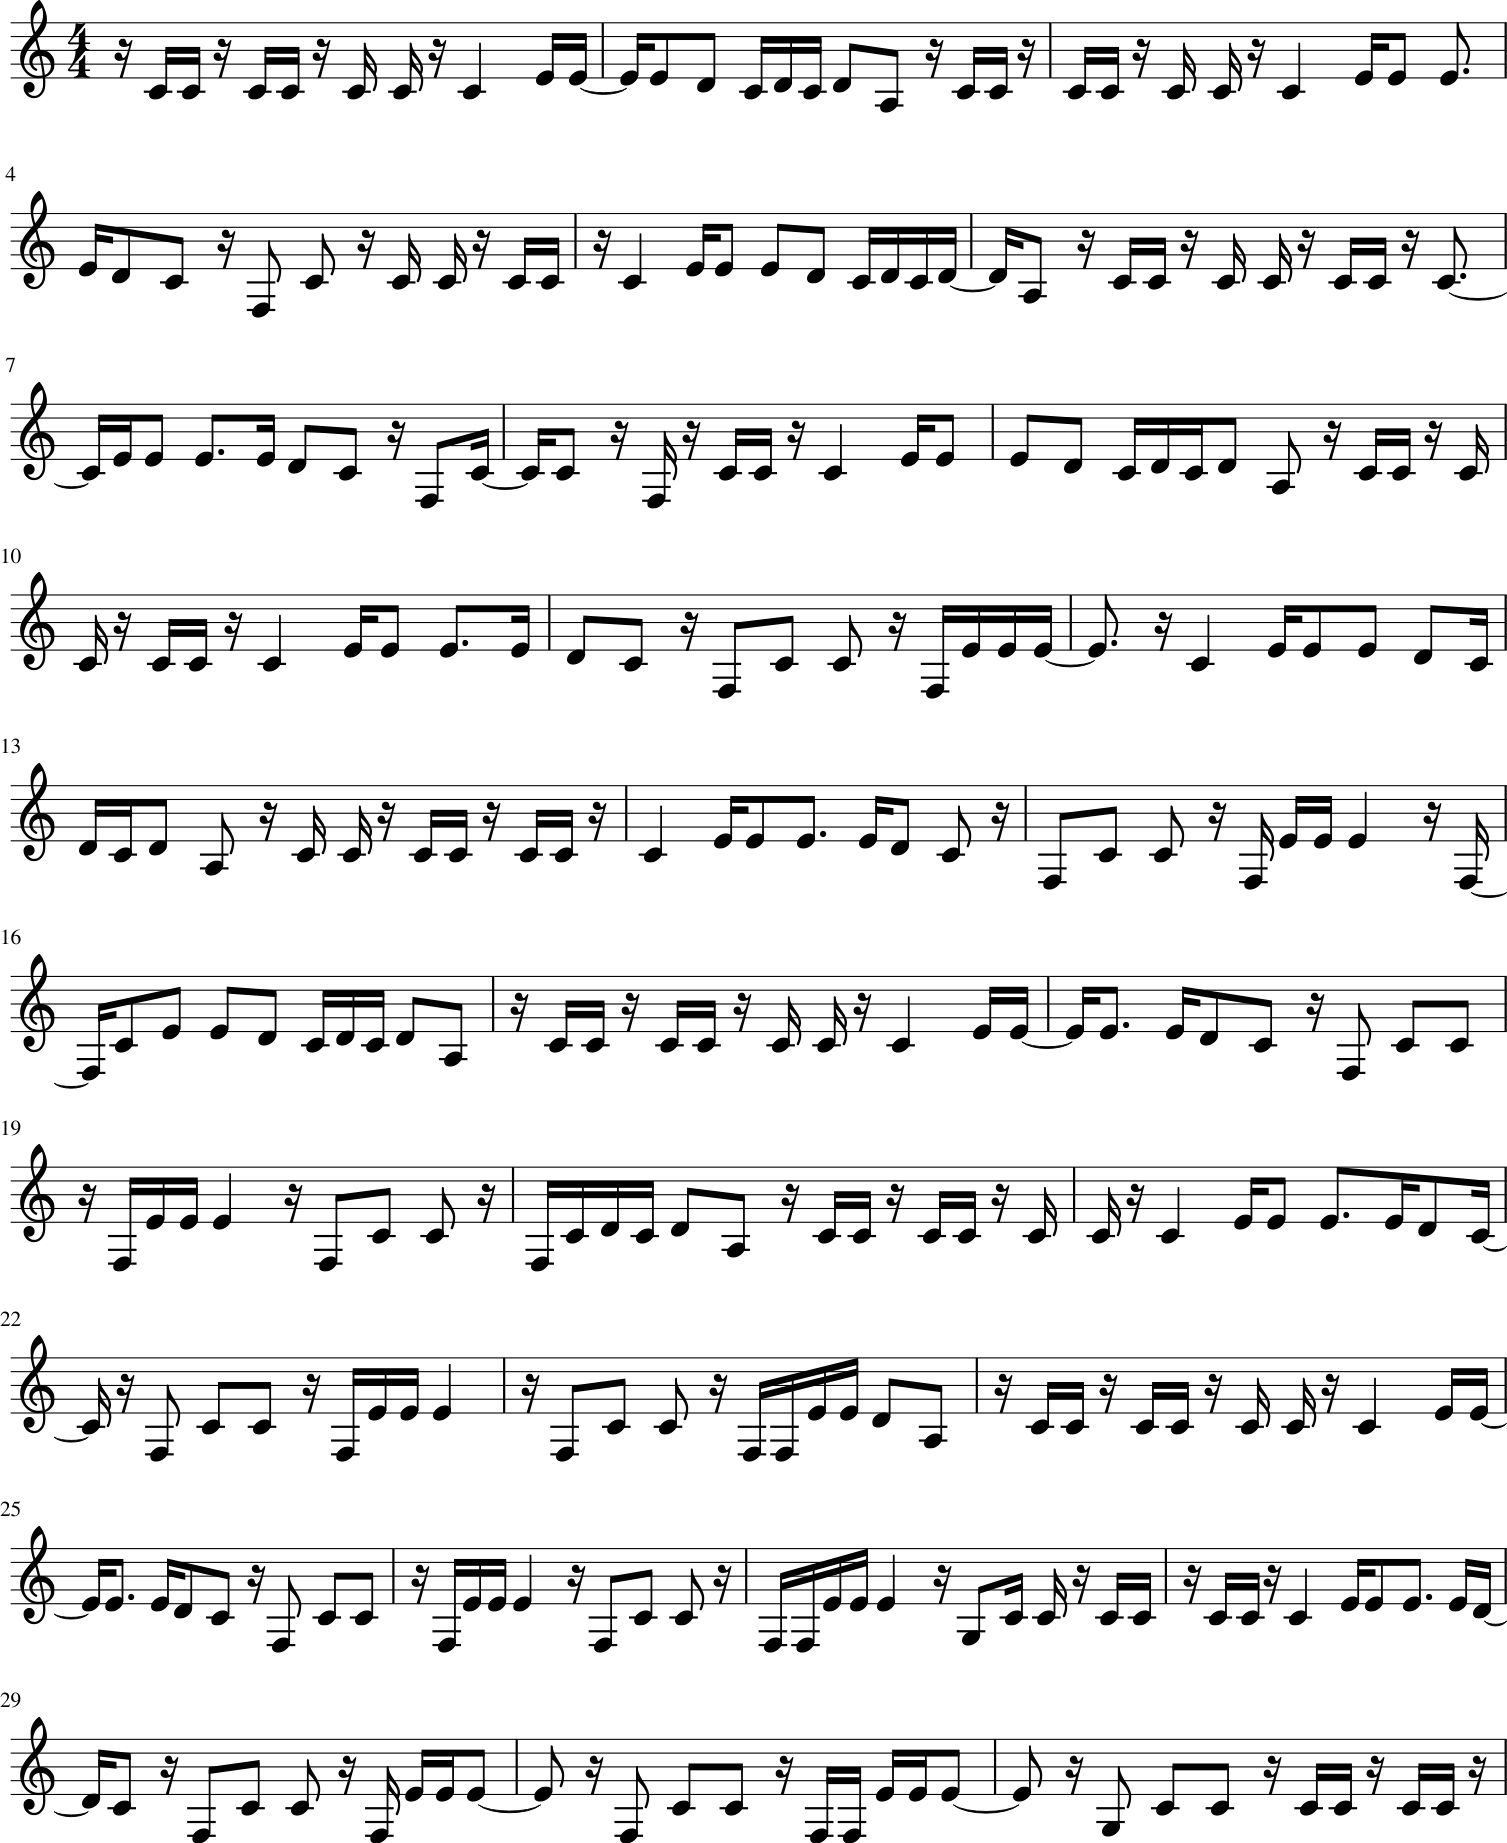

In [293]:
from music21 import *
sc = stream.Score()
for t in nova_sequencia:
    if t[0] == 0.0:
        r = note.Rest(quarterLength = 0.25)
        sc.append(r)
    else:
        n = note.Note(midi=t[0], quarterLength=t[1])
        sc.append(n)
sc.show()

In [294]:
filename = "gerada_" + datetime.now().strftime("%Y%m%d-%H%M%S"+".mid")

In [295]:
print(filename)

gerada_20180707-225603.mid


In [296]:
from music21 import *
mf = midi.translate.streamToMidiFile(sc)
mf.open(filename, 'wb')
mf.write()
mf.close()

In [297]:
!pwd

/home/eurismar/notebooks/JohaNN
